## Timeseries exercise

We are given a dataset containing the monthly sales of a product for several years. Our task is to predict the sales for the next 12 months. 


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from pmdarima import preprocessing as ppc
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import matplotlib.ticker as tkr
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet

STEP 1: EDA and first glance at data

In [2]:
df = pd.read_csv(r"C:\Users\konch\Downloads\Data Scientist Challenge (1)\Data Scientist Challenge\data\time_series\time_series_data.csv", parse_dates=['Date'])

In [3]:
df.head()

,Date,Value
0,2015-01-31,606.714153
1,2015-02-28,64.259063
2,2015-03-31,942.735267
3,2015-04-30,1910.599950
4,2015-05-31,480.986812


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    108 non-null    datetime64[ns]
 1   Value   108 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.8 KB


Specifying Date as index

In [5]:
df = df.set_index("Date")
df.head()

,Value
Date,
2015-01-31,606.714153
2015-02-28,64.259063
2015-03-31,942.735267
2015-04-30,1910.599950
2015-05-31,480.986812


In [6]:
df.tail()

,Value
Date,
2023-08-31,8837.629273
2023-09-30,9571.144195
2023-10-31,15136.480760
2023-11-30,11803.662540
2023-12-31,10184.577810


In [7]:
df.describe()

,Value
count,108.000000
mean,5403.154759
std,3446.955128
min,64.259063
25%,2294.274932
50%,5307.002255
75%,7994.371191
max,15136.480760


New Dataset to explore sales by month

In [8]:
df_month = df.reset_index()
df_month['Month'] = df_month['Date'].dt.month

df_month

,Date,Value,Month
0,2015-01-31,606.714153,1
1,2015-02-28,64.259063,2
2,2015-03-31,942.735267,3
3,2015-04-30,1910.599950,4
4,2015-05-31,480.986812,5
...,...,...,...
103,2023-08-31,8837.629273,8
104,2023-09-30,9571.144195,9
105,2023-10-31,15136.480760,10
106,2023-11-30,11803.662540,11


In [9]:
# Replacing numerical values with Month Names


df_month['Month']=df_month['Month'].replace(to_replace =[1,2,3,4,5,6,7,8,9,10,11,12],  
value =["January","February","March","April","May","June","July","August","September","October","November","December"])

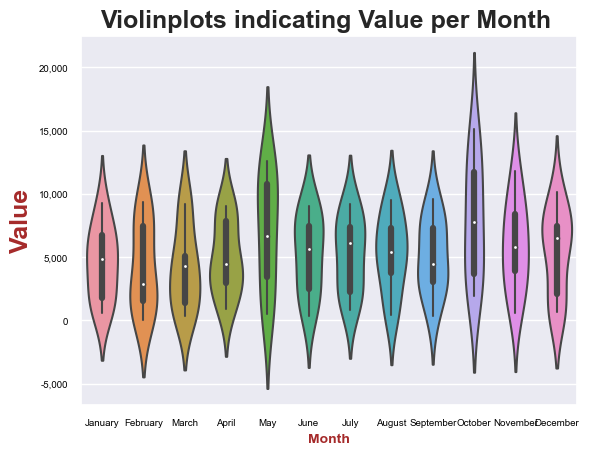

In [10]:
ax=sns.violinplot(data = df_month, y = 'Value', x = 'Month')
ax.set_title('Violinplots indicating Value per Month ',fontweight="bold",fontsize=18)
ax.set_ylabel('Value',fontweight="bold",fontsize=18,color="brown")
ax.set_xlabel("Month",fontweight="bold",fontsize=10,color="brown")
ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y,  p: format(int(y), ',')))
plt.xticks(fontsize=7,color="black")
plt.yticks(fontsize=7,color="black")
plt.show()

We can see that the most profitable months are October and May. They also have the longest violins, meaning there is significant fluctuation.
Worst seem to be September and February.





#### Decomposition

We have chosen multiplicative model because there is a multiplicative increasing trend. We observe that there is a strong increasing trend with also very strong seasonality. 

So we understand that we should create a model that would include also the seasonal effect.

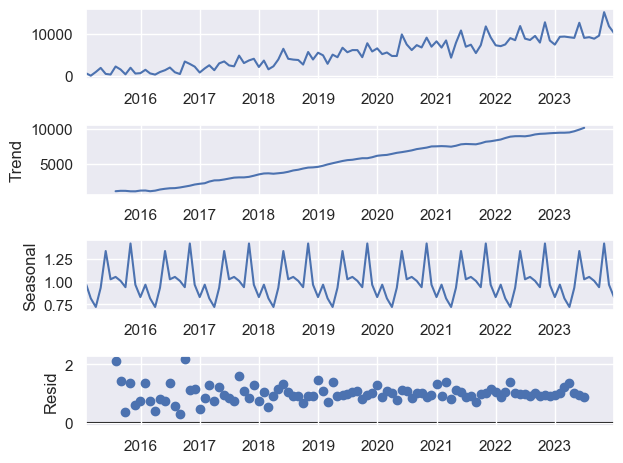

In [11]:
decomposition = sm.tsa.seasonal_decompose(df, model = "multiplicative")
fig = decomposition.plot()
plt.show()

### Checking stationarity (Plotting and Dickey-Fuller test)

In [12]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

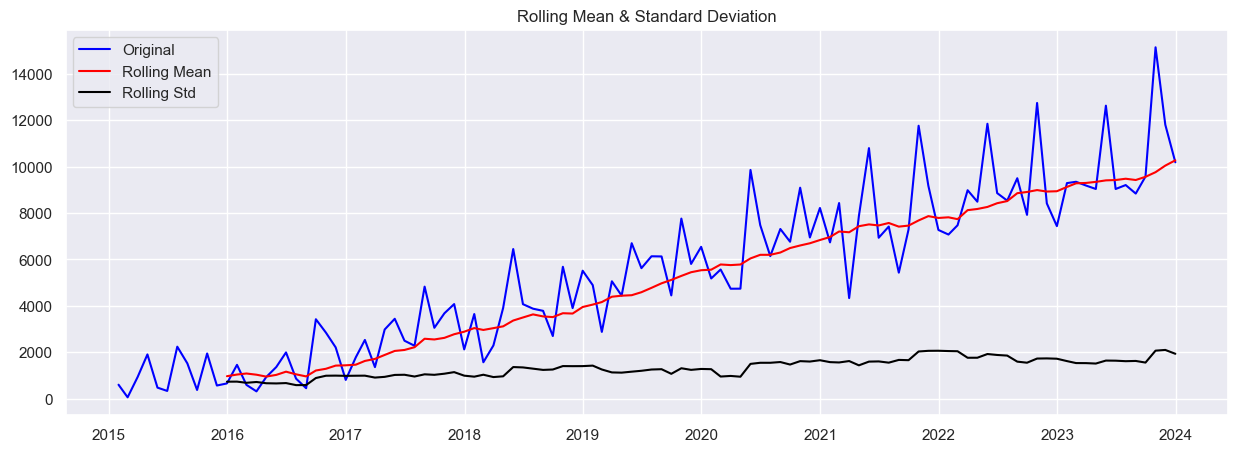

Results of Dickey-Fuller Test:
Test Statistic                  0.523421
p-value                         0.985568
#Lags Used                     11.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64


In [13]:
test_stationarity(df['Value'])

It is clearly observed that we do not have a stationary series.

1) Mean and std are not constant over time

2) p-value> 0.05

3) Test Statistic > all Critical values

Thus we don't have a stationary series

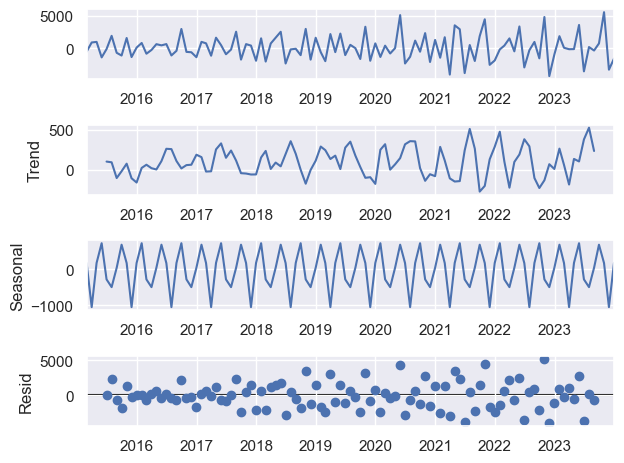

In [14]:
# Taking difference in order to create a stationary series

df_diff = df.diff()
df_diff = df_diff.dropna()


#Plotting again the decomposition to check the diffenced series
dec = sm.tsa.seasonal_decompose(df_diff,period = 8).plot()
plt.show()

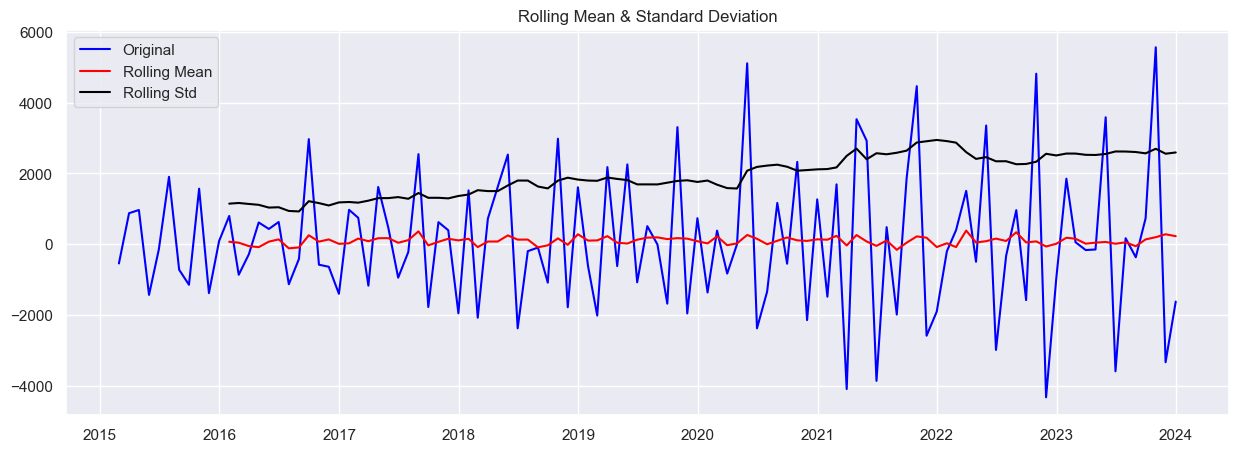

Results of Dickey-Fuller Test:
Test Statistic                -6.485386e+00
p-value                        1.264695e-08
#Lags Used                     1.000000e+01
Number of Observations Used    9.600000e+01
Critical Value (1%)           -3.500379e+00
Critical Value (5%)           -2.892152e+00
Critical Value (10%)          -2.583100e+00
dtype: float64


In [15]:
test_stationarity(df_diff)

Test Statistic (-6.485386e+00) < Critical Value (1%) (-3.500379)

p-value (1.264695e-08) < 0.01

In this case, the test statistic is less than the critical value, and the p-value is less than the significance level (0.01). 

This indicates that we can reject the null hypothesis, and after differencing, the time series is likely stationary.

### STEP 2 : Setting up the models and forecasting

To forecast sales, we will use an Arima and a Prophet model

We start with Arima

c:\Users\konch\anaconda3\envs\py39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


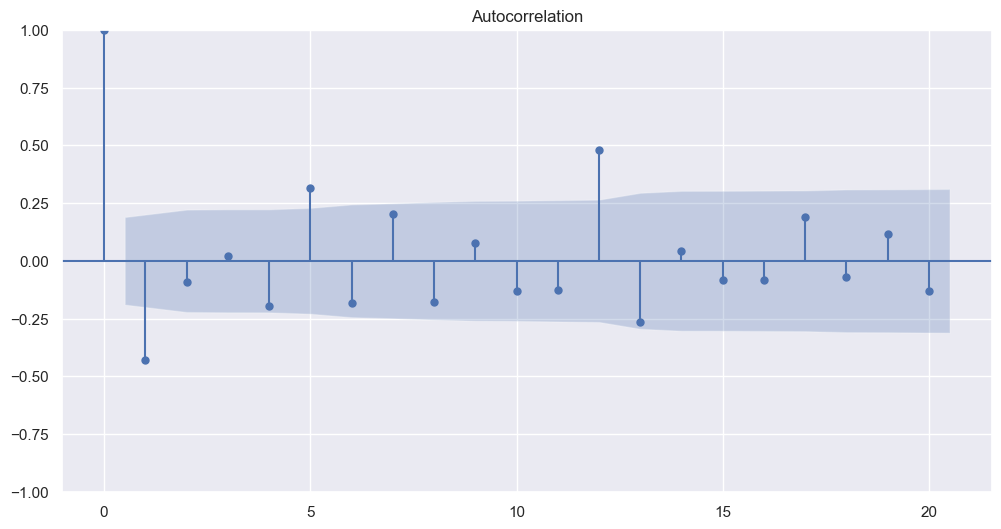

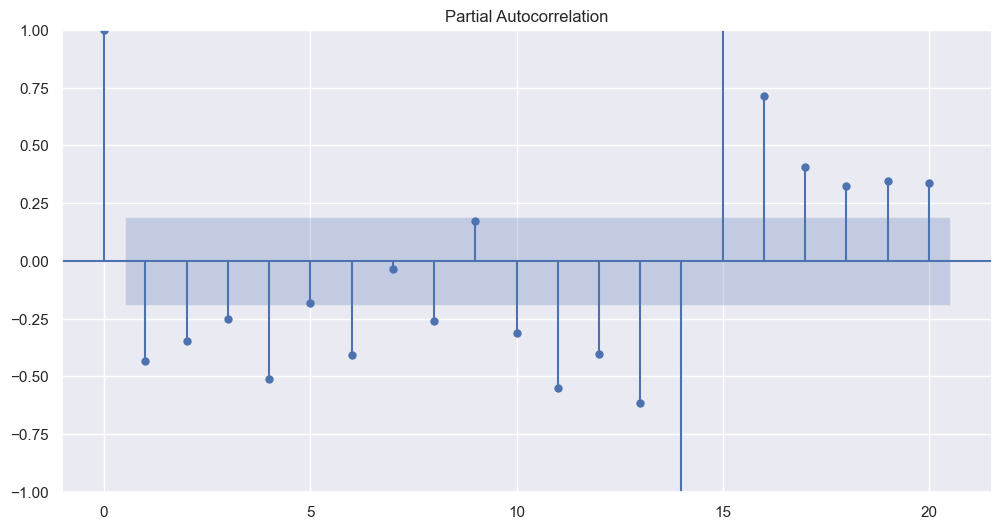

In [16]:
# Autocorrelation and Partial Autocorrelation plots
plt.figure(figsize=(12, 6))
plot_acf(df_diff, lags=20, ax=plt.gca(), title='Autocorrelation')
plt.figure(figsize=(12, 6))
plot_pacf(df_diff, lags=20, ax=plt.gca(), title='Partial Autocorrelation')
plt.show()

Based on the interpretation of the ACF and PACF values, a possible ARIMA model would be ARIMA(1, 1, 3), indicating one autoregressive term (p = 1), one difference to achieve stationarity (d = 1), and three moving average terms (q = 3).

In [17]:
#Train - Test split

train_size = int(len(df) * 0.8)
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

<function matplotlib.pyplot.show(close=None, block=None)>

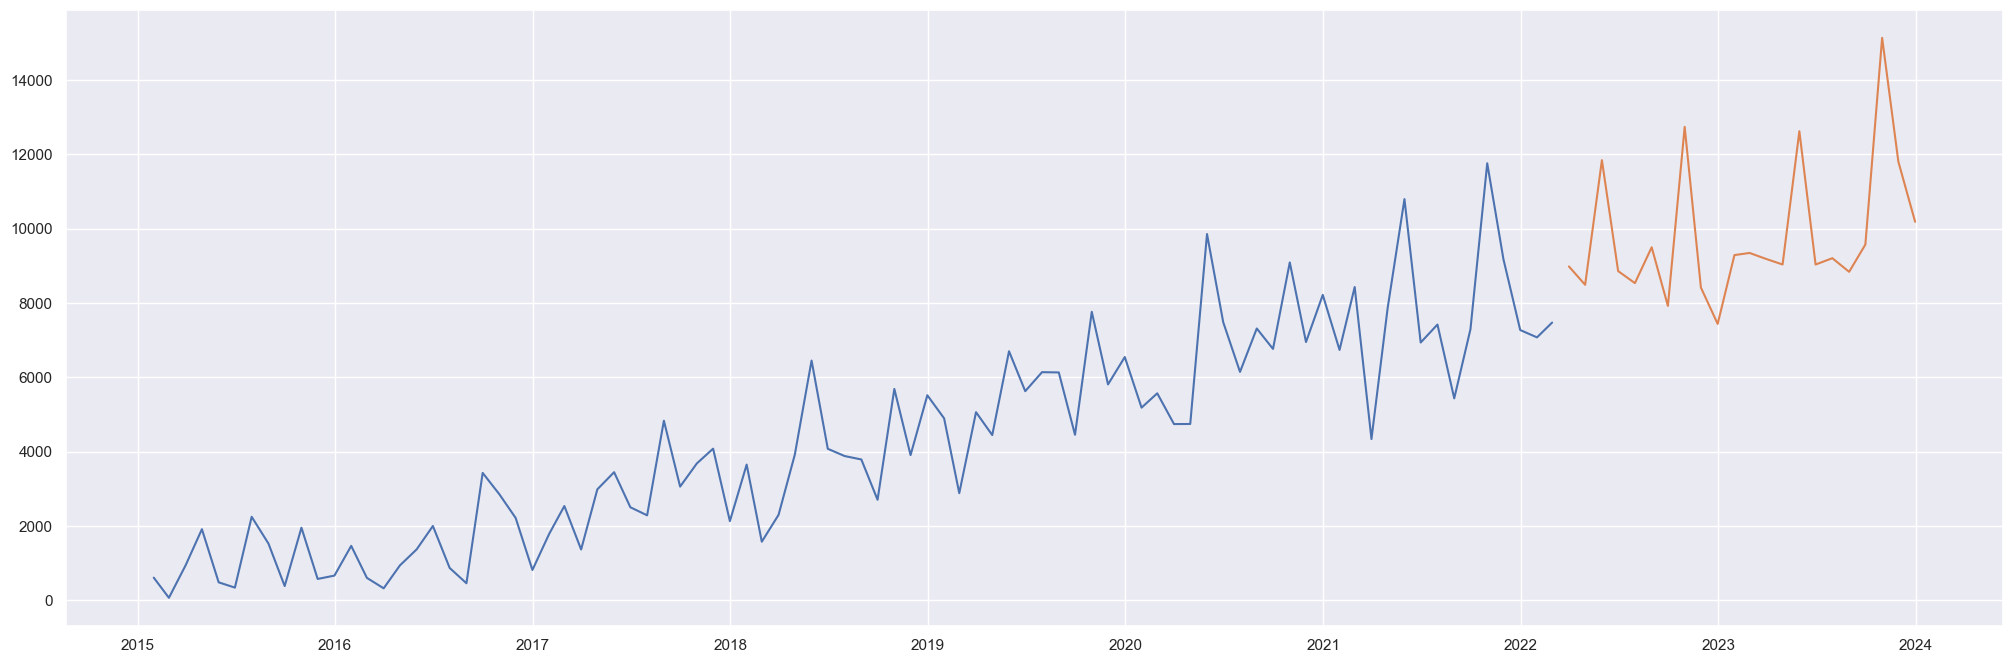

In [18]:
plt.figure(figsize=(25,8))
plt.plot(train_data)
plt.plot(test_data)
plt.show

In [19]:
# Building a baseline ARIMA Model

ar = pm.arima.ARIMA(order=(1,1,3))
ar.fit(train_data)

c:\Users\konch\anaconda3\envs\py39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\konch\anaconda3\envs\py39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(order=(1, 1, 3))

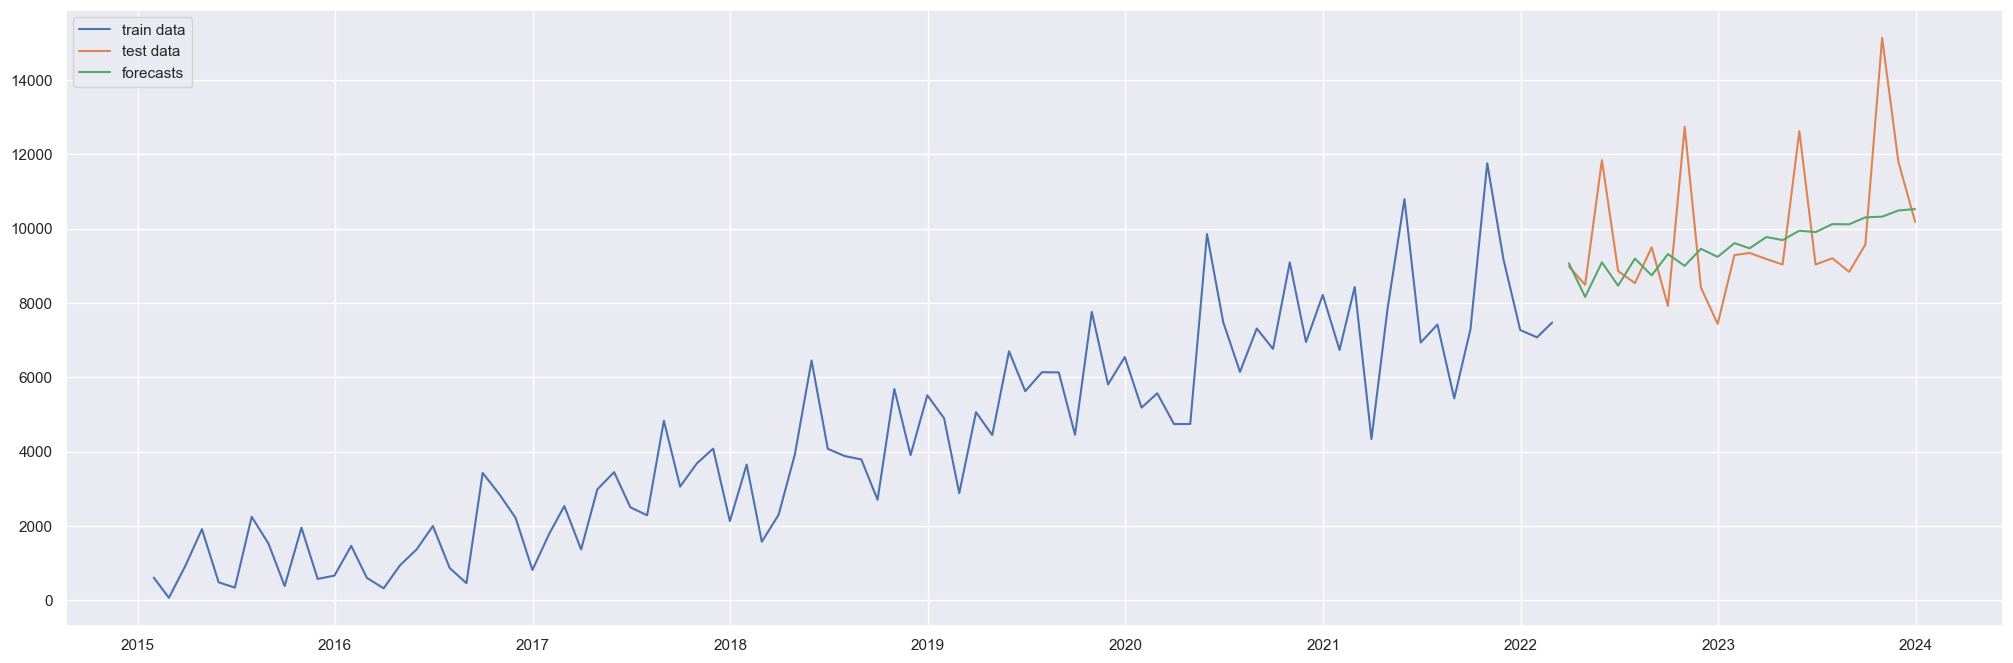

In [20]:
y_pred_ar = pd.DataFrame(ar.predict(n_periods=22), index=test_data.index, columns=['pred'])
plt.figure(figsize=(25,8))
plt.plot(train_data, label='train data')
plt.plot(test_data, label='test data')
plt.plot(y_pred_ar, label='forecasts')
plt.legend()
plt.show()

#### Fine-tuning to take into account seasonal component

c:\Users\konch\anaconda3\envs\py39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


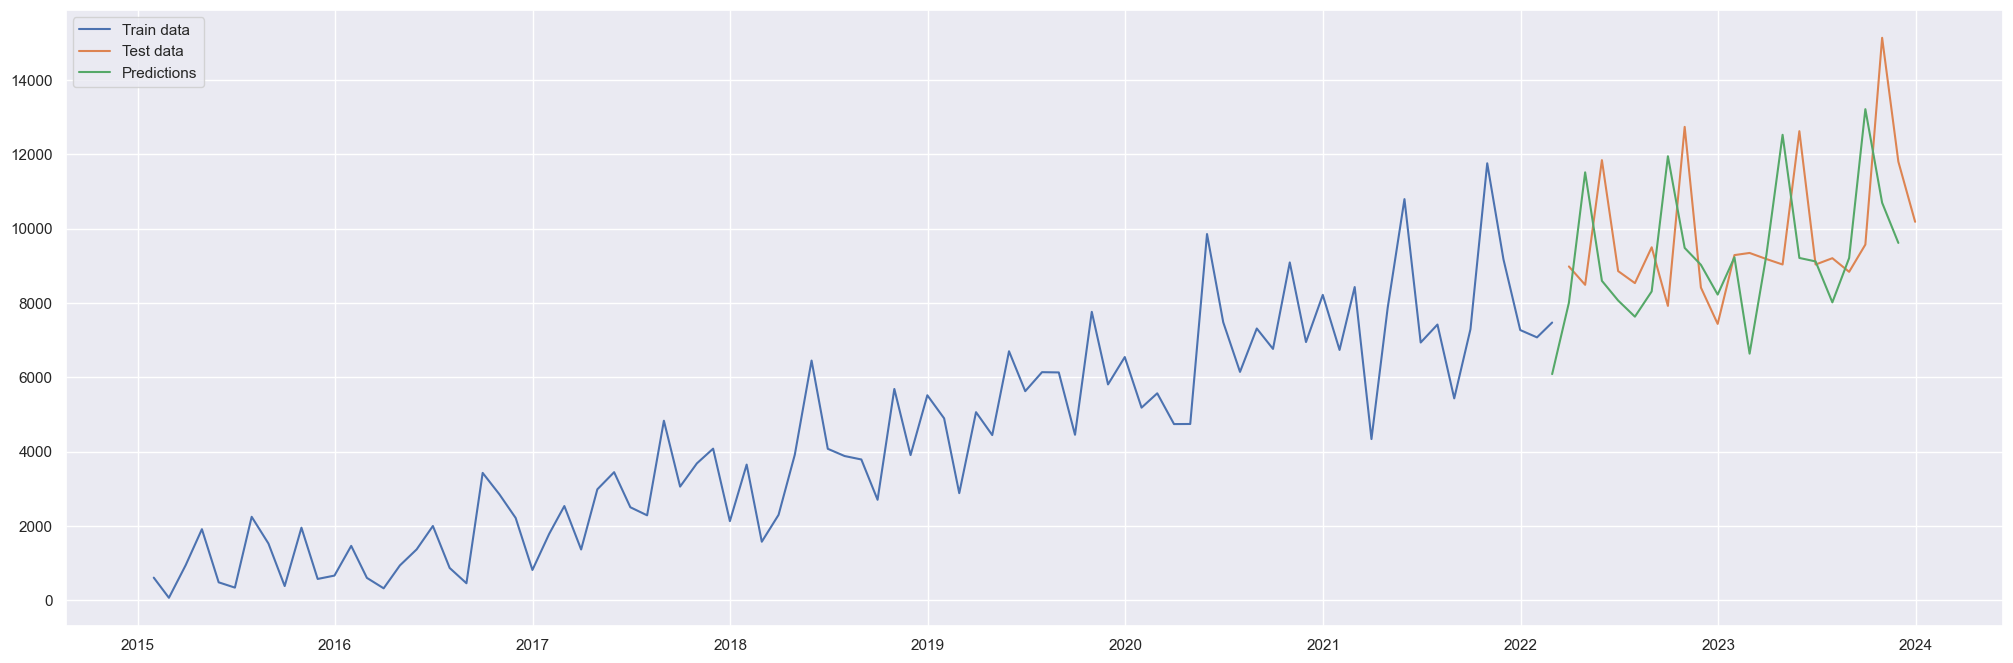

In [21]:
sarima_model = pm.arima.ARIMA(order=(1, 1, 3), seasonal_order=(1, 1, 0, 12))
sarima_model.fit(train_data)

y_pred_sar = sarima_model.predict(n_periods=22)

# Create a DataFrame for the predicted values
y_pred_df = pd.DataFrame(y_pred_sar, index=pd.date_range(start=train_data.index[-1], periods=22, freq='M'), columns=['pred'])

# Plot the training data, test data, and predictions
plt.figure(figsize=(25, 8))
plt.plot(train_data['Value'], label='Train data')
plt.plot(test_data['Value'], label='Test data')
plt.plot(y_pred_df, label='Predictions')
plt.legend()
plt.show()


#### Prophet Model

In [22]:
new_df = pd.DataFrame(train_data)
new_df.reset_index(level = 0, inplace=True)
new_df.columns = ['ds', 'y']
new_df

,ds,y
0,2015-01-31,606.714153
1,2015-02-28,64.259063
2,2015-03-31,942.735267
3,2015-04-30,1910.599950
4,2015-05-31,480.986812
...,...,...
81,2021-10-31,11758.701360
82,2021-11-30,9174.809933
83,2021-12-31,7271.169034
84,2022-01-31,7073.469014


In [23]:
m = Prophet()

m.fit(new_df)

# Make future dataframe
future = m.make_future_dataframe(periods=22, freq='M')
#future.tail()

# Predict 
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

18:14:08 - cmdstanpy - INFO - Chain [1] start processing
18:14:08 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
103,2023-08-31,10708.364935,9626.011127,11815.188972
104,2023-09-30,9227.089083,8084.854800,10352.604468
105,2023-10-31,12147.263009,11089.717181,13321.393528
106,2023-11-30,10481.936333,9324.453287,11609.906415
107,2023-12-31,10853.347282,9671.834574,12003.020540


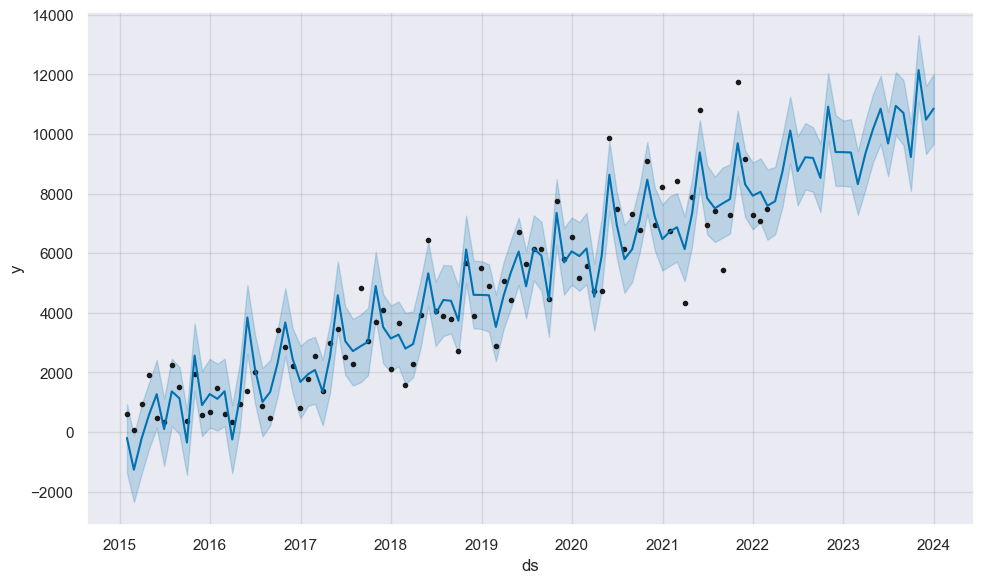

In [24]:
# Plot the forecast
fig1 = m.plot(forecast)

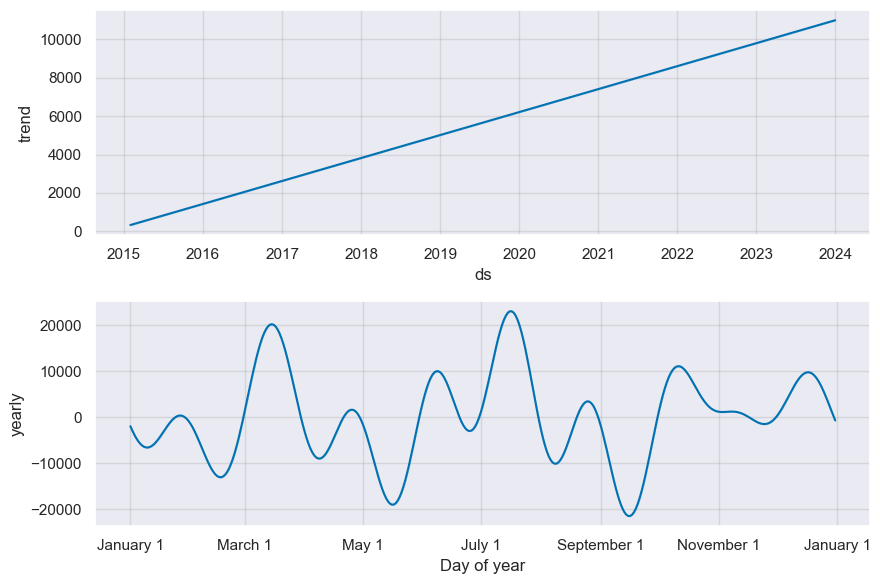

In [25]:
# Plot the forecast components
fig2 = m.plot_components(forecast)

### STEP 3: Comparing model performance

SARIMA RMSE: 1182.1108832710418
Prophet RMSE: 1302.4782820556766


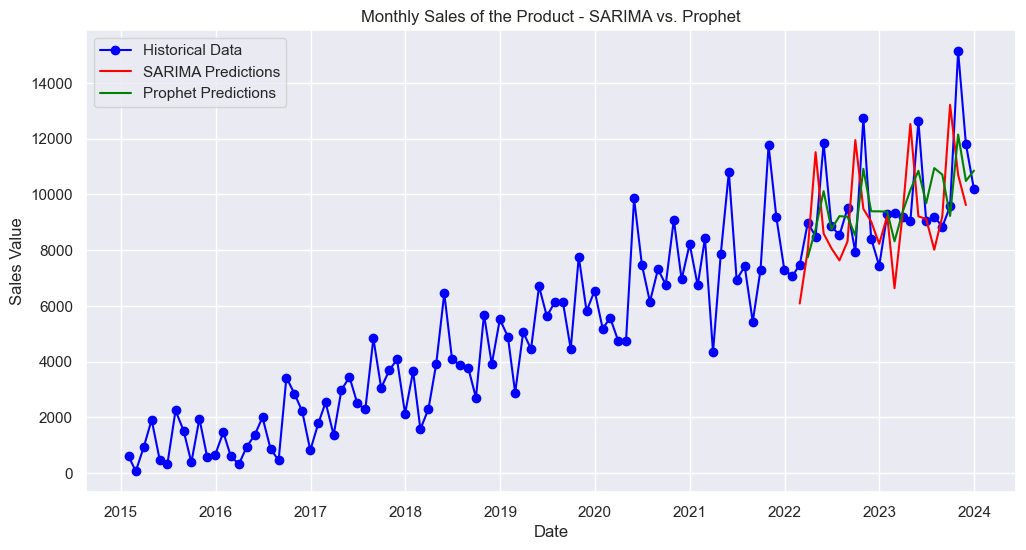

In [26]:
# Calculating RMSE for SARIMA model
sarima_rmse = np.sqrt(mean_squared_error(test_data['Value'], y_pred_sar))

# Calculating RMSE for Prophet model
prophet_rmse = np.sqrt(mean_squared_error(test_data['Value'], forecast.iloc[-22:]['yhat']))

# Comparing the RMSE values of ARIMA and Prophet models
print(f"SARIMA RMSE: {sarima_rmse}")
print(f"Prophet RMSE: {prophet_rmse}")

# Plotting the predictions alongside historical data
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Value'], label='Historical Data', marker='o', color='blue')
plt.plot(y_pred_df.index, y_pred_df['pred'], label='SARIMA Predictions', color='red')
plt.plot(forecast.iloc[-22:]['ds'], forecast.iloc[-22:]['yhat'], label='Prophet Predictions', color='green')
plt.xlabel('Date')
plt.ylabel('Sales Value')
plt.title('Monthly Sales of the Product - SARIMA vs. Prophet')
plt.legend()
plt.grid(True)
plt.show()


### After plotting all forecasts we can see that the Sarima model has a smaller RMSE and is closer to the actual data than Prophet